<a href="https://colab.research.google.com/github/Monica-Phutane/Mlops/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
from datetime import datetime  #import datetime
start_date="2020-01-01"
end_date_forecast="2025-07-24"
#datetime.now().strftime('%Y-%m-%d')
print(f"\nToday:{end_date_forecast}")

#1.download data
ticker="SBIN.NS"
data=yf.download(ticker,start=start_date,end=end_date_forecast)

if not data.empty:
    # Access the 'High' column using the MultiIndex
    d_high=data[('High', ticker)]

    length=len(data)
    print("\n===========================================================")
    print(f"company:{ticker}")
    print(f"length:{length}")
    print("\n==========================================================")
    print(d_high.tail(5))
else:
    print(f"Could not download data for {ticker} for the specified date range.")


Today:2025-07-24


/tmp/ipython-input-13-3000253577.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(ticker,start=start_date,end=end_date_forecast)
[*********************100%***********************]  1 of 1 completed


company:SBIN.NS
length:1378

Date
2025-07-17    842.500000
2025-07-18    832.650024
2025-07-21    827.349976
2025-07-22    828.049988
2025-07-23    825.200012
Name: (High, SBIN.NS), dtype: float64


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 - 4s - 28ms/step - loss: 0.0175
Epoch 2/100
137/137 - 1s - 9ms/step - loss: 1.9122e-04
Epoch 3/100
137/137 - 1s - 6ms/step - loss: 1.3306e-04
Epoch 4/100
137/137 - 2s - 13ms/step - loss: 1.2616e-04
Epoch 5/100
137/137 - 1s - 10ms/step - loss: 1.2231e-04
Epoch 6/100
137/137 - 1s - 7ms/step - loss: 1.1691e-04
Epoch 7/100
137/137 - 1s - 6ms/step - loss: 1.2020e-04
Epoch 8/100
137/137 - 1s - 6ms/step - loss: 1.2103e-04
Epoch 9/100
137/137 - 1s - 7ms/step - loss: 1.2126e-04
Epoch 10/100
137/137 - 1s - 9ms/step - loss: 1.3975e-04
Epoch 11/100
137/137 - 1s - 9ms/step - loss: 1.1981e-04
Epoch 12/100
137/137 - 1s - 9ms/step - loss: 1.2844e-04
Epoch 13/100
137/137 - 1s - 7ms/step - loss: 1.2409e-04
Epoch 14/100
137/137 - 1s - 9ms/step - loss: 1.4345e-04
Epoch 15/100
137/137 - 1s - 7ms/step - loss: 1.1053e-04
Epoch 16/100
137/137 - 1s - 10ms/step - loss: 1.1299e-04
Epoch 17/100
137/137 - 1s - 10ms/step - loss: 1.0596e-04
Epoch 18/100
137/137 - 1s - 8ms/step - loss: 1.0425e-04
Epoch 19/100

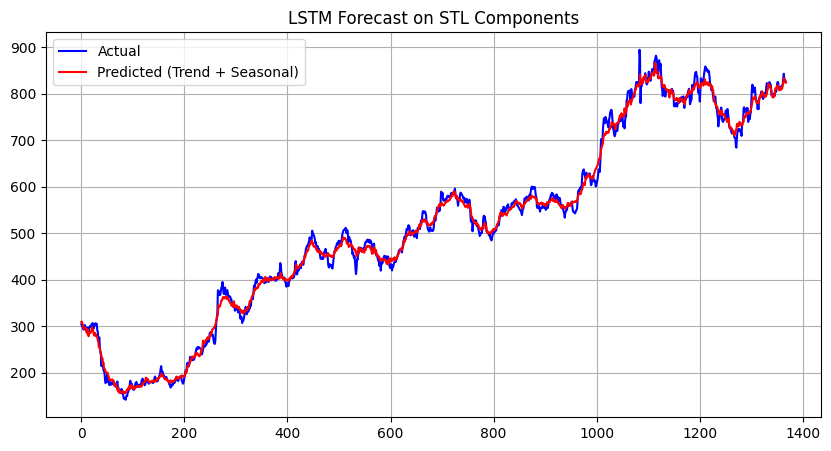

final RMSE(reconstructed):12.8878
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
forecast for next day(Trend + Seasonal):815.5486


In [ ]:
from statsmodels.tsa.seasonal import STL

#1. STL Decomposition
stl=STL(d_high,period=30)
result=stl.fit()
trend=result.trend
seasonal=result.seasonal
residl=result.resid      # optional

#2.sequence preparation function
def prepare_lstm_data(series,window_size):
  scaler=MinMaxScaler()
  scaled=scaler.fit_transform(series.values.reshape(-1,1))
  x,y=[],[]
  for i in range(len(scaled)-window_size):
    x.append(scaled[i:i+window_size])
    y.append(scaled[i+window_size])
  return np.array(x),np.array(y),scaler

window_size=10
x_trend,y_trend,scaler_trend=prepare_lstm_data(trend,window_size)
x_seasonal,y_seasonal,scaler_seasonal=prepare_lstm_data(seasonal,window_size)

#3.LSTM Builder
def build_and_train_lstm(x,y,epochs=100):
  model=Sequential([
      LSTM(50, return_sequences=False, input_shape=(x.shape[1],1)),
      Dense(1)
  ])
  model.compile(optimizer='adam',loss='mse')
  model.fit(x,y,epochs=epochs,batch_size=10,verbose=2)
  return model

#4.train models
model_trend=build_and_train_lstm(x_trend,y_trend)
model_seasonal=build_and_train_lstm(x_seasonal,y_seasonal)

#5.predictions & inverse scaling
y_pred_trend=model_trend.predict(x_trend)
y_pred_seasonal=model_seasonal.predict(x_seasonal)

trend_pred=scaler_trend.inverse_transform(y_pred_trend)
seasonal_pred=scaler_seasonal.inverse_transform(y_pred_seasonal)

#6.final forecast
final_pred=trend_pred.flatten()+seasonal_pred.flatten()
actual=d_high.values[window_size:]

#7.plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(actual,label='Actual',color='blue')
plt.plot(final_pred,label='Predicted (Trend + Seasonal)', color='red')
plt.title("LSTM Forecast on STL Components")
plt.legend()
plt.grid(True)
plt.show()

#8.RMSE
rmse=np.sqrt(mean_squared_error(actual,final_pred))
print(f"final RMSE(reconstructed):{rmse:.4f}")

# forecast 1 step ahead for trend
last_trend_window = trend.values[-window_size:].reshape(1,window_size,1)
last_trend_scaled=scaler_trend.transform(last_trend_window.reshape(window_size,1)).reshape(1,window_size,1)
next_trend_scaled = model_trend.predict(last_trend_scaled)
next_trend = scaler_trend.inverse_transform(next_trend_scaled)[0][0]

# forecast 1-step ahead for seasonal
last_seasonal_window = seasonal.values[-window_size:].reshape(1,window_size,1)
last_seasonal_scaled=scaler_seasonal.transform(last_seasonal_window.reshape(window_size,1)).reshape(1,window_size,1)
next_seasonal_scaled = model_seasonal.predict(last_seasonal_scaled)
next_seasonal = scaler_seasonal.inverse_transform(next_seasonal_scaled)[0][0]

# final forecast
next_day_forecast_high_LSTM = next_trend + next_seasonal
print(f"forecast for next day(Trend + Seasonal):{next_day_forecast_high_LSTM:.4f}")